In [30]:
import copy
import scanpy as sc
import numpy as np
import pickle
import pandas as pd
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scover.data.utils import *
from scover.net.seqnet import *

import warnings
from pytorch_lightning.utilities.warnings import LightningDeprecationWarning

warnings.filterwarnings("ignore", category=LightningDeprecationWarning)

# Running scover

In this example, I am using the bone marrow dataset from Tabula Muris (see parts 1 and 2). As this is a mock example, I am only running the network for a few epochs with a limited hyperparameter sweep. As such, the results are not representative, but this notebook is designed to show how to go from input data to analysing the output data.

In [2]:
ad = sc.read("data/Marrow_pooled.h5ad")
# Check if sequence information is there:
ad.var

,symbol,nonz_counts,promoter_seq
0610005C13Rik,0610005C13Rik,36,ttggtcatctgaatctggaggtctgcagcctgagagaaagaaataa...
0610007P14Rik,0610007P14Rik,1901,gggaccacgctctgcttcacctccctcctccttccccagcccgaat...
0610009B22Rik,0610009B22Rik,1076,gaagtcaatgatttttagccaaagtagcttcgaaatgtctgtttaa...
0610009L18Rik,0610009L18Rik,440,gaggagtgcagtccccaccccgggcggcgtaaccgtcggctaccgg...
0610009O20Rik,0610009O20Rik,1189,attagccagatatctctttggtggttaagttacatcgcaaaaggtt...
...,...,...,...
Zyx,Zyx,3310,cttgtccccggggcaatactattgcaggcgggtctagggcaaagcg...
Zzef1,Zzef1,1642,ggctcagcaccacaccaagcccgcatatcctcagcatctatacagc...
Zzz3,Zzz3,1400,agatggcaggtgtgatagtcagtataactataattggtattcttta...
a,a,21,ccgccctcagcctgctgctcctccctcgtgtcctcccgcccgtcag...


Let's check the data:

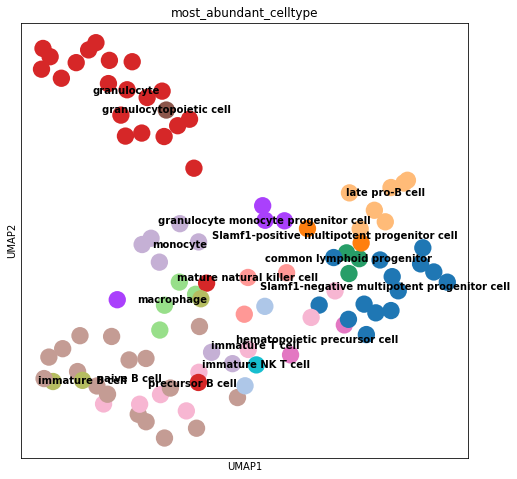

In [3]:
mpl.rcParams["figure.figsize"] = (8, 8)
sc.pl.umap(ad, color='most_abundant_celltype', legend_loc='on data')

## Filter genes based on expression:

(100, 16288)

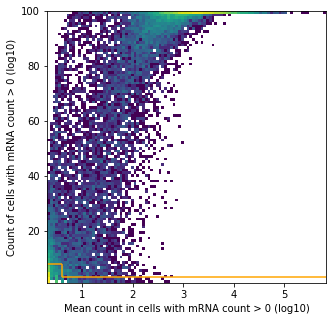

In [4]:
mpl.rcParams["figure.figsize"] = (5, 5)

# To avoid dividing by 0
sc.pp.filter_genes(ad, min_cells=1)

# calculate the mean of each gene across non-zero cells
n_cells = (ad.X > 0).sum(0)
nonz_mean = ad.X.sum(0) / n_cells

plt.hist2d(nonz_mean, n_cells, bins=100, norm=mpl.colors.LogNorm())

nonz_mean_cutoff = np.log10(4)  # cut off for expression in non-zero cells
cell_count_cutoff = ad.shape[
    0] * 0.03  # cut off percentage for cells with higher expression
cell_count_cutoff2 = ad.shape[
    0] * 0.08  # cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff,
           cell_count_cutoff,
           cell_count_cutoff2,
           color='orange')
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, max(nonz_mean), color='orange')
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='orange')
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)')
plt.ylabel('Count of cells with mRNA count > 0 (log10)')

# Everything below the orange line is excluded
ad[:, ((np.array(nonz_mean > nonz_mean_cutoff)
        | np.array(n_cells > cell_count_cutoff2))
       & np.array(n_cells > cell_count_cutoff))].shape

Apply the filter:

In [5]:
ad = ad[:, ((np.array(nonz_mean > nonz_mean_cutoff)
             | np.array(n_cells > cell_count_cutoff2))
            & np.array(n_cells > cell_count_cutoff))]

## Convert sequences to sequence tensor

In [6]:
X_seqs = seq_list_to_conv(list(ad.var['promoter_seq']), expand=True)
X_seqs.shape

(16288, 1, 1000, 4)

## Get count data from the AnnData object

I transpose the data matrix because I want genes by cells, not cells by genes. (The batches are along the gene axis)

In [7]:
X_data = ad.X.T
X_data.shape

(16288, 100)

# Setting up the hyperparameter search with Ray Tune + Pytorch Lightning

## Get train-val-test splits

In [8]:
k_outer = 10
idx_sets = get_splits(ind_list = list(range(X_data.shape[0])),
                           n_splits = k_outer)
len(idx_sets['test'])

10

## Run the training loop

For this, you will require a GPU, otherwise this might take a long time. (It is possible if you set `num_gpus` to `0`).

One way to keep track of the runs while they are running is to open a terminal after the runs have started and run `tensorboard --logdir $logdir` where `$logdir` is `{exp_name}_tune` (so in this case the full command would be `tensorboard --logdir Marrow_pool80_tune`. This opens a tensorboard session with live-updating plots for the different runs:

|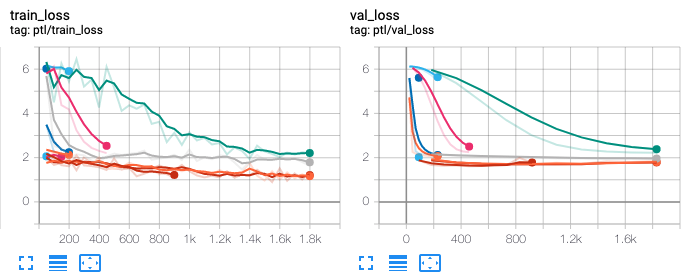|
|:-----:|
|Example outputs in tensorboard|

Specify parameters and output directories below. This is a toy example, usually `trials_per_outer` is set to `100`, and `epochs_per_hyperparam_opt` is set to `40`.

Sometimes, to make `ray` work, it might require you to start a local head node with `ray start --head` before running this notebook, but it's worth trying without first.

In [9]:
exp_name = "Marrow_pool80"
trials_per_outer = 2
epochs_per_hyperparam_opt = 10
final_epochs = 10
num_gpus = 1 if torch.cuda.is_available() else 0

In [10]:
print(f'Number of GPUs used: {num_gpus}')

Number of GPUs used: 1


In [11]:
pickle.dump(idx_sets, open(f"models/{exp_name}_backup_idx_sets.p", "wb"))

all_analyses = []
for curr_outer in range(k_outer):
    curr_train_idx = idx_sets['inner_train'][curr_outer]
    curr_val_idx = idx_sets['val'][curr_outer]
    curr_test_idx = idx_sets['test'][curr_outer]
    train_data = SeqDataset(X_seqs[curr_train_idx],
                            X_data[curr_train_idx],
                            dtype="float")
    val_data = SeqDataset(X_seqs[curr_val_idx],
                          X_data[curr_val_idx],
                          dtype="float")
    curr_analysis = tune_scover_asha_hyperopt(
        train_data,
        val_data,
        num_samples=trials_per_outer,
        num_epochs=epochs_per_hyperparam_opt,
        local_dir=f"./{exp_name}_tune",
        prefix=f"{exp_name}_" + str(curr_outer),
        gpus_per_trial=1 if num_gpus > 0 else 0,
        use_elu=True)
    all_analyses.append(curr_analysis)
    best_config = curr_analysis.get_best_config(metric='loss', mode='min')
    train_loader = DataLoader(train_data,
                              batch_size=best_config["batch_size"],
                              num_workers=2,
                              shuffle=True)
    val_loader = DataLoader(val_data,
                            batch_size=best_config["batch_size"],
                            num_workers=2,
                            shuffle=False)
    seq_length = train_loader.dataset[0][0].shape[1]
    output_size = train_loader.dataset[0][1].shape[0]
    sn = SeqNet(seq_length=seq_length,
                output_size=output_size,
                learning_rate=best_config["learning_rate"],
                motif_length=12,
                num_motifs=600,
                sigma_motifs=best_config["sigma_motifs"],
                sigma_net=best_config["sigma_net"],
        use_elu=True)
    early_stop_callback = EarlyStopping(monitor='ptl/val_loss',
                                        patience=4,
                                        verbose=False,
                                        mode='min')
    trainer = pl.Trainer(max_epochs=final_epochs,
                         gpus=1 if num_gpus > 0 else 0,
                         callbacks=[early_stop_callback])
    trainer.fit(sn, train_loader, val_loader)
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    torch.save(sn.state_dict(), state_dict_path)

all_best_configs = [
    x.get_best_config(metric="loss", mode="min") for x in all_analyses
]
pickle.dump(all_best_configs,
            open(f"models/{exp_name}_backup_all_best_configs.p", "wb"))

(train_scover_bs pid=34881) GPU available: True, used: True
(train_scover_bs pid=34881) TPU available: False, using: 0 TPU cores
(train_scover_bs pid=34881) IPU available: False, using: 0 IPUs
(train_scover_bs pid=34881) HPU available: False, using: 0 HPUs
(train_scover_bs pid=34881) /nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train_scover_bs pid=34881)   rank_zero_deprecation(
(train_scover_bs pid=34881) /nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
(train_scover_bs pid=34881)   rank_zero_deprecation(
(train_scover_bs pid=34881) /nfs/team218/jh4

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_scover_bs_705cfd12,2023-06-22_14-56-02,True,,81de37ebc59243869b7cd7446c401059,dgx-c11-02,10,1.8518,10.160.0.15,34881,27.7542,1.90923,27.7542,1687442162,0,,10,705cfd12,0.00632095
train_scover_bs_75fe813c,2023-06-22_14-56-19,True,,8f8868032d48451089a95efe78910126,dgx-c11-02,2,2.11346,10.160.0.15,35051,8.39842,0.990827,8.39842,1687442179,0,,2,75fe813c,0.0102854


(train_scover_bs pid=35051) GPU available: True, used: True
(train_scover_bs pid=35051) TPU available: False, using: 0 TPU cores
(train_scover_bs pid=35051) IPU available: False, using: 0 IPUs
(train_scover_bs pid=35051) HPU available: False, using: 0 HPUs
(train_scover_bs pid=35051) /nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train_scover_bs pid=35051)   rank_zero_deprecation(
(train_scover_bs pid=35051) /nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
(train_scover_bs pid=35051)   rank_zero_deprecation(
(train_scover_bs pid=35051) /nfs/team218/jh4

Best hyperparameters found were:  {'batch_size': 256, 'learning_rate': 0.0008104849235201821, 'sigma_motifs': 0.0003988943148765434, 'sigma_net': 8.598964091796609e-05}


Sanity Checking: 0it [00:00, ?it/s]

/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (46) is sm

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Calculate PWMs of motifs

The PWMs are representations of what subsequences are activated by each of the convolutional filters in the neural network.

In [12]:
all_pfm_dicts = {}
all_ppm_dicts = {}
for curr_outer in range(k_outer):
    curr_train_idx = idx_sets['inner_train'][curr_outer]
    curr_test_idx = idx_sets['test'][curr_outer]
    curr_val_idx = idx_sets['val'][curr_outer]

    train_data = SeqDataset(X_seqs[curr_train_idx],
                            X_data[curr_train_idx],
                            dtype="float")
    train_loader = DataLoader(train_data,
                              batch_size=128,
                              num_workers=0,
                              shuffle=False)

    sn = SeqNet(seq_length=seq_length,
                output_size=output_size,
                learning_rate=all_best_configs[curr_outer]["learning_rate"],
                motif_length=12,
                num_motifs=600,
                sigma_motifs=all_best_configs[curr_outer]["sigma_motifs"],
                sigma_net=all_best_configs[curr_outer]["sigma_net"],
                use_elu=True)
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    sn.load_state_dict(torch.load(state_dict_path))

    sn = sn.to(torch.device('cuda'))
    sn.eval()

    curr_pfm_dict, curr_ppm_dict = align_conv_filters(sn, train_loader)

    all_pfm_dicts[curr_outer] = curr_pfm_dict
    all_ppm_dicts[curr_outer] = curr_ppm_dict

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

## Save MEME file with motifs

In [13]:
all_motifs_ppm_dict = {}
for i, can_nr in enumerate(range(k_outer)):
    for key in all_ppm_dicts[i].keys():
        all_motifs_ppm_dict[str(can_nr) + "_" + key] = all_ppm_dicts[i][key]

# Save big MEME file with all motifs
all_meme_output_path = f"output/{exp_name}_all_MEME_motifs.txt"
save_meme(all_motifs_ppm_dict, all_meme_output_path)

wrote meme list


In [14]:
all_motifs_pfm_dict = {}
for i, can_nr in enumerate(range(k_outer)):
    for key in all_pfm_dicts[i].keys():
        all_motifs_pfm_dict[str(can_nr) + "_" + key] = all_pfm_dicts[i][key]
pickle.dump(all_motifs_pfm_dict,
            open(f"output/{exp_name}_all_motifs_pfm_dict.p", "wb"))

## Calculate influence scores

This is how to calculate the influence scores for individual convolutional filters for setting their weights to 0 and assessing the difference in the output (a bit like a saturation mutagenesis experiment, but at the level of feature extraction rather than the input). Here the influence scores are abbreviated LOO for leave-one-out.

In [15]:
all_loo_scores = np.zeros((600 * k_outer, output_size))
for curr_outer in range(k_outer):
    curr_train_idx = idx_sets['inner_train'][curr_outer]
    curr_test_idx = idx_sets['test'][curr_outer]
    curr_val_idx = idx_sets['val'][curr_outer]

    val_data = SeqDataset(X_seqs[curr_val_idx],
                          X_data[curr_val_idx],
                          dtype="float")
    val_loader = DataLoader(val_data,
                            batch_size=128,
                            num_workers=0,
                            shuffle=False)

    sn = SeqNet(seq_length=seq_length,
                output_size=output_size,
                learning_rate=all_best_configs[curr_outer]["learning_rate"],
                motif_length=12,
                num_motifs=600,
                sigma_motifs=all_best_configs[curr_outer]["sigma_motifs"],
                sigma_net=all_best_configs[curr_outer]["sigma_net"],
                use_elu=True)

    # Load current candidate model
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    sn.load_state_dict(torch.load(state_dict_path))

    sn = sn.to(torch.device('cuda'))
    sn.eval()

    data_loader = val_loader
    device = torch.device("cuda")

    n_seq = len(data_loader.dataset)
    seq_len = data_loader.dataset[0][0].shape[1]
    d = sn.conv_1.weight.shape[0]
    m = sn.conv_1.weight.shape[2]

    fc_cpu = copy.deepcopy(sn.fc).cpu()

    # Get activations
    activations = torch.FloatTensor(size=(n_seq, d, 1,
                                          1))  # assumes padding=0, strides=1
    curr_i = 0
    for idx, (seqs, vals) in enumerate(tqdm(data_loader)):
        curr_batch_size = len(seqs)
        seqs = seqs.to(device)
        with torch.no_grad():
            activations[curr_i:curr_i + curr_batch_size, :, :, :] = sn.pool_1(
                sn.nonlin(sn.conv_1(seqs))).detach().cpu()
        curr_i += curr_batch_size

    # Get normal prediction
    normal_prediction = torch.FloatTensor(size=(n_seq, sn.output_size))
    curr_i = 0
    for idx, (seqs, vals) in enumerate(tqdm(data_loader)):
        curr_batch_size = len(seqs)
        seqs = seqs.to(device)
        with torch.no_grad():
            normal_prediction[curr_i:curr_i + curr_batch_size, :] = sn(seqs)
        curr_i += curr_batch_size
    normal_prediction = normal_prediction.numpy()

    # Using the model activations, predict the output when iteratively setting a motif to zeroes only.
    zeroes_fill = torch.zeros((activations.shape[0], 1, 1)).cpu()
    left_out_curr_model = np.zeros((sn.num_motifs, sn.output_size))
    for i in tqdm(range(d)):
        curr_set_0 = torch.clone(activations)
        curr_set_0[:, i, :, :] = torch.clone(zeroes_fill)
        curr_set_0 = curr_set_0.view(-1, d)
        all_loo_scores[(sn.num_motifs * curr_outer) + i, :] = np.mean(
            normal_prediction - fc_cpu(curr_set_0.cpu()).detach().numpy(),
            axis=0)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Save:

In [16]:
pickle.dump(all_loo_scores, open(f"output/{exp_name}_all_loo_scores_1.p",
                                 "wb"))

In [17]:
num_motifs = int(all_loo_scores.shape[0] / k_outer)
all_motif_names = [
    str(x) + "_" + str(y) for x in [x for x in range(k_outer)]
    for y in [y for y in range(num_motifs)]
]
all_loo_scores_df = pd.DataFrame(all_loo_scores,
                                 index=all_motif_names,
                                 columns=ad.obs_names)
all_loo_scores_df

,pseudobulk_0,pseudobulk_1,pseudobulk_2,pseudobulk_3,pseudobulk_4,pseudobulk_5,pseudobulk_6,pseudobulk_7,pseudobulk_8,pseudobulk_9,...,pseudobulk_90,pseudobulk_91,pseudobulk_92,pseudobulk_93,pseudobulk_94,pseudobulk_95,pseudobulk_96,pseudobulk_97,pseudobulk_98,pseudobulk_99
0_0,0.002754,0.005730,0.002982,0.002063,0.002531,0.004221,0.005830,0.003027,0.000815,0.001981,...,0.005316,0.006265,0.004986,3.072525e-03,0.009127,0.009527,0.004163,0.010615,0.004490,0.001802
0_1,-0.000040,0.000001,-0.000075,0.000001,-0.000088,-0.000033,0.000012,0.000017,-0.000038,-0.000030,...,0.000019,-0.000002,-0.000003,2.042887e-07,-0.000029,-0.000014,-0.000027,-0.000011,0.000018,0.000027
0_2,0.000718,0.000797,0.000836,0.001041,0.000542,0.000851,0.000880,0.000862,0.001031,0.001252,...,0.000691,0.000899,0.001182,1.250157e-03,0.000858,0.000714,0.001043,0.000878,0.000785,0.000704
0_3,0.004848,0.008304,0.006804,0.008990,0.004562,0.010287,0.008654,0.007982,0.005970,0.003024,...,0.009053,0.009241,0.013385,8.726026e-03,0.009804,0.009274,0.009259,0.011824,0.005580,0.005974
0_4,0.000089,0.000080,0.000070,-0.000031,0.000138,0.000017,-0.000015,0.000111,-0.000004,-0.000058,...,0.000059,0.000019,0.000020,7.470536e-05,0.000061,0.000096,0.000030,-0.000005,0.000035,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_595,0.005096,0.004265,0.005171,0.004411,0.005511,0.004215,0.003226,0.003755,0.004263,0.004588,...,0.004284,0.004288,0.004055,4.865722e-03,0.004256,0.004786,0.003783,0.004999,0.003318,0.003324
9_596,0.003743,0.002725,0.003824,0.003401,0.003825,0.003266,0.002782,0.002670,0.003019,0.003153,...,0.003157,0.003652,0.003498,3.257470e-03,0.003079,0.003640,0.002730,0.003834,0.002733,0.002883
9_597,0.002950,0.002554,0.003010,0.002464,0.003298,0.002580,0.001697,0.002170,0.002367,0.002434,...,0.002767,0.002401,0.002382,3.076361e-03,0.002859,0.002516,0.002266,0.002649,0.001554,0.001887
9_598,0.004144,0.003478,0.004231,0.003682,0.004252,0.003465,0.002992,0.003079,0.003728,0.003768,...,0.003744,0.003847,0.003506,3.867519e-03,0.003726,0.004055,0.003285,0.004294,0.002929,0.003140


In [18]:
all_loo_scores_df.to_csv(f"output/{exp_name}_all_loo_scores_df.csv")

## Load in motif cluster database

I compiled the motif cluster resource from [this source](https://www.vierstra.org/resources/motif_clustering).

In [21]:
jvdf = pd.read_csv("../resources/motif_annotations_with_possible_gene.csv",
                   index_col=0)
jvdf

,Cluster_ID,Motif,Database,Consensus,Relative_orientation,Width,Left_offset,Right_offset,Cluster_name,Cluster_type,mouse_gene,human_gene
0,1,LHX6_homeodomain_3,Taipale_Cell_2013,TGATTGCAATCA,+,12,0,0,HD/1:homeodomain,homeodomain,Lhx6,LHX6
1,1,Lhx8.mouse_homeodomain_3,Taipale_Cell_2013,TGATTGCAATTA,-,12,0,0,HD/1:homeodomain,homeodomain,Lhx8,LHX8
2,2,LHX2_MOUSE.H11MO.0.A,HOCOMOCO_v11,ACTAATTAAC,-,10,7,9,HD/2:homeodomain,homeodomain,Lhx2,LHX2
3,2,LHX2_HUMAN.H11MO.0.A,HOCOMOCO_v11,AACTAATTAAAA,-,12,6,8,HD/2:homeodomain,homeodomain,Lhx2,LHX2
4,2,LHX3_MOUSE.H11MO.0.C,HOCOMOCO_v11,TTAATTAGC,-,9,8,9,HD/2:homeodomain,homeodomain,Lhx3,LHX3
...,...,...,...,...,...,...,...,...,...,...,...,...
2169,284,Ahr+Arnt_MA0006.1,Jaspar2018,TGCGTG,+,6,2,1,AHR:bHLH,bHLH,Ahr,AHR
2170,285,KLF8_HUMAN.H11MO.0.C,HOCOMOCO_v11,CAGGGGGTG,+,9,0,0,KLF/SP/3:C2H2,C2H2,Klf8,KLF8
2171,285,KLF8_MOUSE.H11MO.0.C,HOCOMOCO_v11,CAGGGGGTG,+,9,0,0,KLF/SP/3:C2H2,C2H2,Klf8,KLF8
2172,286,ZSCAN4_MA1155.1,Jaspar2018,TGCACACACTGAAAA,+,15,0,0,ZSCAN4:C2H2,C2H2,Zscan4,ZSCAN4


In [22]:
subcluster_gene_sets = {}
for cluster in jvdf["Cluster_name"].unique():
    subcluster_gene_sets[cluster] = list(
        jvdf[jvdf["Cluster_name"] == cluster]["mouse_gene"].unique())
cluster_gene_sets = {}
for cluster in jvdf["Cluster_type"].unique():
    cluster_gene_sets[cluster] = list(
        jvdf[jvdf["Cluster_type"] == cluster]["mouse_gene"].unique())

## Align motifs database using Tomtom

For the next bit, it is necessary to install Tomtom from the MEME suite using e.g. `conda install -c bioconda meme`. This takes a little while to run. Set `-verbosity 2` to see the outputs here.

In [23]:
!tomtom -o output/tomtom_$exp_name -thresh 0.05 \
  'output/'$exp_name'_all_MEME_motifs.txt' ../resources/Mus_musculus.meme \
  -verbosity 1

## Load aligned motifs and assign to motif clusters

In [24]:
alignment_df = create_alignment_df(
    f"output/tomtom_{exp_name}/tomtom.tsv",
    threshold=0.05,
    translate_ids=True,
    db_meme_file="../resources/Mus_musculus.meme")

/lustre/scratch123/hgi/mdt2/teams/parts/jh47/SCOVER_REBUTTAL/scoverdev/scover_new_repo_tmp/example_notebooks/scover/data/utils.py:457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  aln = pd.read_csv(tomtom_path, sep="\t",


In [25]:
aligned_motifs = list(alignment_df['Query_ID'].unique())
aligned_motif_subfamilies = []
aligned_motif_families = []
for i in tqdm(aligned_motifs):
    found = False
    curr_df = alignment_df[alignment_df['Query_ID'] == i]
    for aln in curr_df['Target_ID']:
        if aln in list(jvdf['mouse_gene']):
            # Found the motif family.
            aligned_motif_subfamilies.append(
                jvdf[jvdf['mouse_gene'] == aln]['Cluster_name'].iloc[0])
            aligned_motif_families.append(
                jvdf[jvdf['mouse_gene'] == aln]['Cluster_type'].iloc[0])
            found = True
            break
    if not found:
        aligned_motif_subfamilies.append("N/A")
        aligned_motif_families.append("N/A")
motif_families = pd.DataFrame(
    {
        'motif': aligned_motifs,
        'family': aligned_motif_families,
        'subfamily': aligned_motif_subfamilies
    },
    index=aligned_motifs)

  0%|          | 0/877 [00:00<?, ?it/s]

In [26]:
all_loo_scores_df_aligned = all_loo_scores_df.loc[aligned_motifs]

## Summarise aligned motif scores across motif families

In [27]:
subfams_loo = np.zeros(
    (len(motif_families['subfamily'].unique()), all_loo_scores_df.shape[1]))

In [28]:
subfams_loo = np.zeros(
    (len(motif_families['subfamily'].unique()), all_loo_scores_df.shape[1]))
fams_loo = np.zeros(
    (len(motif_families['family'].unique()), all_loo_scores_df.shape[1]))
for idx, subfam in enumerate(motif_families['subfamily'].unique()):
    curr_s = [
        x for x in all_loo_scores_df_aligned.index
        if motif_families.loc[x]["subfamily"] == subfam
    ]
    curr_df = all_loo_scores_df_aligned.loc[curr_s]
    subfams_loo[idx, :] = curr_df.to_numpy().sum(0)
for idx, fam in enumerate(motif_families['family'].unique()):
    curr_s = [
        x for x in all_loo_scores_df_aligned.index
        if motif_families.loc[x]["family"] == fam
    ]
    curr_df = all_loo_scores_df_aligned.loc[curr_s]
    fams_loo[idx, :] = curr_df.to_numpy().sum(0)

subfams_loo_df = pd.DataFrame(subfams_loo,
                              index=motif_families['subfamily'].unique(),
                              columns=all_loo_scores_df.columns)
fams_loo_df = pd.DataFrame(fams_loo,
                           index=motif_families['family'].unique(),
                           columns=all_loo_scores_df.columns)

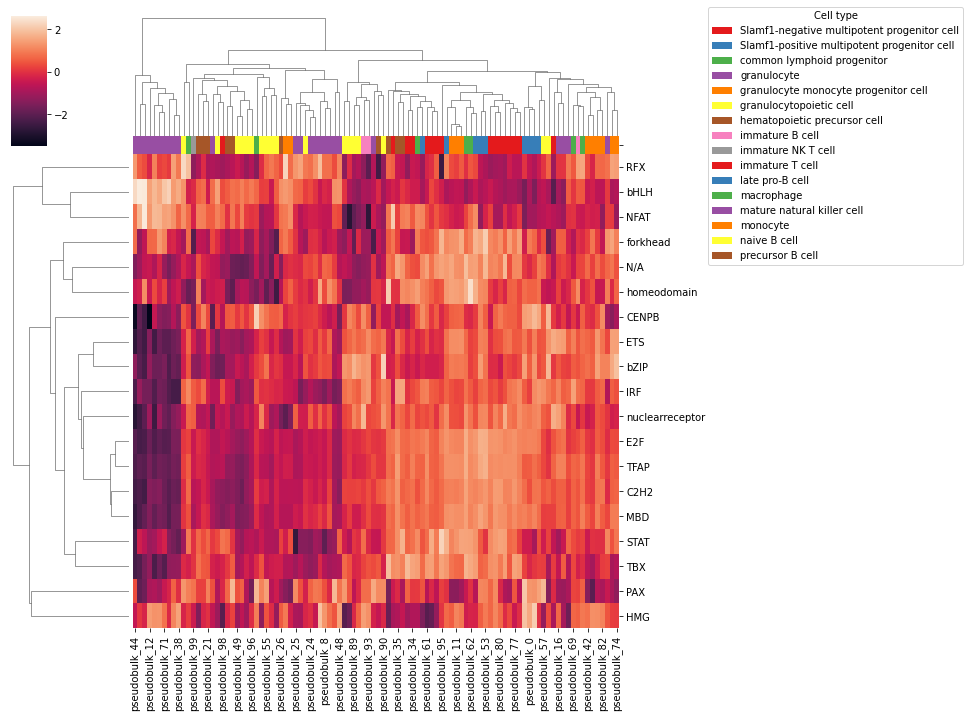

In [31]:
from matplotlib.patches import Patch

network_labels = ad.obs['most_abundant_celltype']
# network_pal = sns.hls_palette(len(set(network_labels)))
# network_pal = sns.color_palette("Set2", len(set(network_labels)))
network_pal = sns.color_palette("Set1", len(set(network_labels)))
network_lut = dict(zip(map(str, sorted(set(network_labels))), network_pal))
network_colors = pd.Series(list(network_labels)).map(network_lut)
network_colors.index = fams_loo_df.columns

sns.clustermap(to_z(fams_loo_df), col_colors=network_colors)

handles = [Patch(facecolor=network_lut[name]) for name in network_lut]
plt.legend(handles,
           network_lut,
           title='Cell type',
           bbox_to_anchor=(1.35, 1),
           bbox_transform=plt.gcf().transFigure,
           loc='upper right')
plt.show()

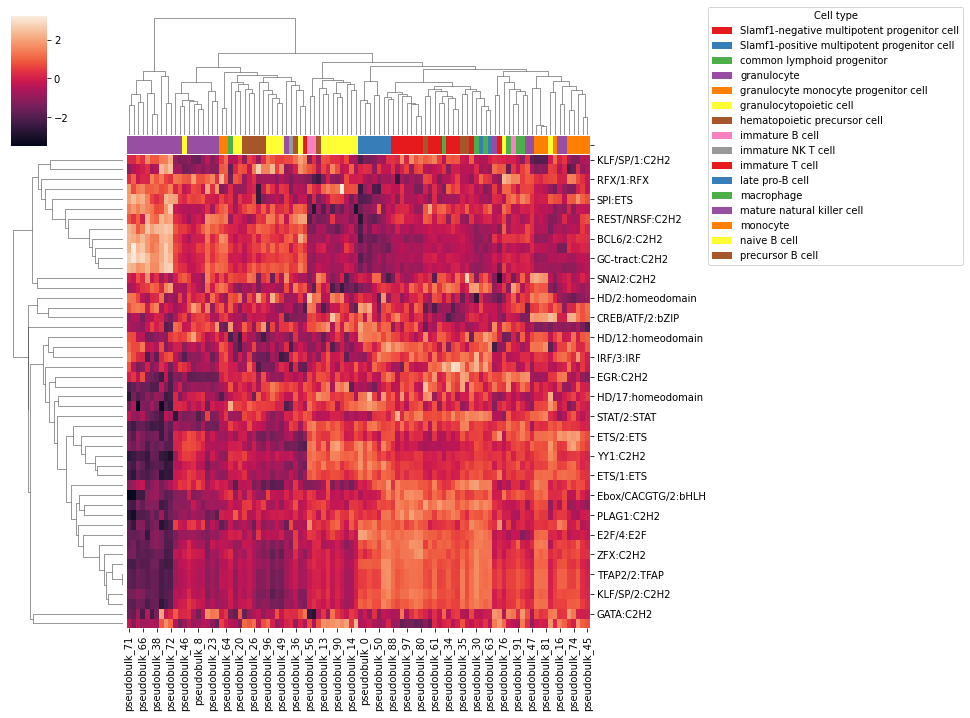

In [32]:
from matplotlib.patches import Patch

network_labels = ad.obs['most_abundant_celltype']
# network_pal = sns.hls_palette(len(set(network_labels)))
# network_pal = sns.color_palette("Set2", len(set(network_labels)))
network_pal = sns.color_palette("Set1", len(set(network_labels)))
network_lut = dict(zip(map(str, sorted(set(network_labels))), network_pal))
network_colors = pd.Series(list(network_labels)).map(network_lut)
network_colors.index = subfams_loo_df.columns

sns.clustermap(to_z(subfams_loo_df), col_colors=network_colors)

handles = [Patch(facecolor=network_lut[name]) for name in network_lut]
plt.legend(handles,
           network_lut,
           title='Cell type',
           bbox_to_anchor=(1.35, 1),
           bbox_transform=plt.gcf().transFigure,
           loc='upper right')
plt.show()

## Calculate motif family reproducibility

In [33]:
fam_repro = {}
subfam_repro = {}
for fam in motif_families["family"].unique():
    curr_df = motif_families[motif_families["family"] == fam]
    fam_repro[fam] = len(set([x.split("_")[0]
                              for x in curr_df["motif"]])) / k_outer
for subfam in motif_families["subfamily"].unique():
    curr_df = motif_families[motif_families["subfamily"] == subfam]
    subfam_repro[subfam] = len(set([x.split("_")[0]
                                    for x in curr_df["motif"]])) / k_outer

In [34]:
motif_families["family_genes"] = [
    list(jvdf[jvdf["Cluster_name"] == x]["mouse_gene"].unique())
    for x in motif_families["subfamily"]
]

In [35]:
# Subset to reproducible motif families
motif_families_repro = motif_families[[
    x in [x for x in subfam_repro if subfam_repro[x] >= 0.5 and x != "N/A"]
    for x in motif_families['subfamily']
]]

## Get correlations to expression levels

In [36]:
expression_hits_df = get_expression_hits_df(ad,
                                            all_loo_scores_df,
                                            motif_families_repro,
                                            fdr_correct=True,
                                            gene_symbols='symbol',
                                            correlation='spearman')

In [37]:
expression_hits_df

,family,gene,mean_expression,correlation,pval
0,ZFX:C2H2,Zfx,3.268468,0.655834,1.307145e-13
0,KLF/SP/2:C2H2,Egr1,3.239816,-0.115104,3.127839e-01
1,KLF/SP/2:C2H2,Egr2,1.261575,-0.108666,3.221059e-01
2,KLF/SP/2:C2H2,Sp1,3.308136,0.629667,9.029765e-12
3,KLF/SP/2:C2H2,Patz1,2.959592,0.808460,2.173999e-23
...,...,...,...,...,...
1,E2F/2:E2F,Tfdp1,3.330987,0.570408,5.818266e-10
2,E2F/2:E2F,E2f4,3.471572,0.880192,1.045319e-32
3,E2F/2:E2F,E2f6,2.662462,0.869617,2.531326e-31
4,E2F/2:E2F,E2f3,2.469711,0.714278,1.443780e-16


## Test set prediction

In [38]:
from scipy.stats import pearsonr

corrs = []
for curr_outer in tqdm(range(k_outer)):
    curr_test_idx = idx_sets['test'][curr_outer]
    test_data = SeqDataset(X_seqs[curr_test_idx], X_data[curr_test_idx], dtype="float")
    test_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)
    best_config = all_best_configs[curr_outer]
    sn = SeqNet(seq_length=seq_length, 
                     output_size=output_size, 
                     learning_rate=best_config["learning_rate"],
                     motif_length=12,
                     num_motifs=600,
                     sigma_motifs=best_config["sigma_motifs"],
                     sigma_net=best_config["sigma_net"],
                     use_elu=True)
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    sn.load_state_dict(torch.load(state_dict_path))
    if torch.cuda.is_available():
        sn = sn.cuda()
    sn = sn.eval()
    
    curr_predictions = np.zeros((len(test_data), output_size))
    curr_ground_truth = np.zeros((len(test_data), output_size))
    curr_start_idx = 0
    for idx, (X,Y) in enumerate(tqdm(test_loader)):
        if torch.cuda.is_available():
            X = X.to(torch.device('cuda'))
        curr_pred = sn(X)
        curr_pred_len = curr_pred.shape[0]
        curr_predictions[curr_start_idx:curr_start_idx+curr_pred_len,:] = curr_pred.detach().cpu().numpy()
        curr_ground_truth[curr_start_idx:curr_start_idx+curr_pred_len,:] = Y.detach().cpu().numpy()
        curr_start_idx += curr_pred_len
    corrs.append(pearsonr(curr_ground_truth.flatten(), curr_predictions.flatten())[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

## Plot example 'fold' correlations

This represents the last fold.

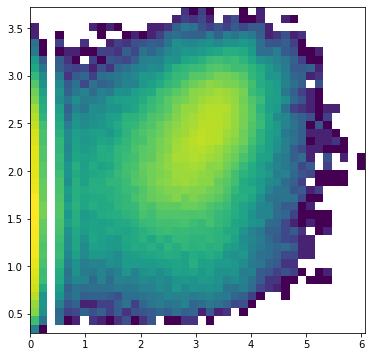

0.46990566775654863


In [39]:
plt.figure(figsize=(6,6))
plt.hist2d(curr_ground_truth.flatten(), curr_predictions.flatten(), 
           norm=mpl.colors.LogNorm(), bins=40);
plt.show()

# Print mean of all correlations:
print(np.mean(corrs))

In [40]:
np.mean(np.array(corrs)*np.array(corrs))

0.22957093086266628

## Example follow-up for correlations

In [41]:
def get_subfam_exp_corr_df(subfam, gene,
                           ad, all_loo_scores_df, motif_families_repro):
    agg_scores = all_loo_scores_df.loc[motif_families[motif_families['subfamily'] == subfam]['motif']] \
                                  .to_numpy().sum(0)
    exp_scores = list(ad[:,gene].X[:,0])
    print("Spearman R = " + str(round(spearmanr(agg_scores,exp_scores)[0], 2)))
    return pd.DataFrame({'agg_scores': agg_scores,
                         'exp_scores': exp_scores,
                         'most_abundant_celltype': ad.obs['most_abundant_celltype'].copy()})

In [42]:
motif_families_repro['subfamily'].unique()

array(['ZFX:C2H2', 'KLF/SP/2:C2H2', 'YY1:C2H2', 'Ebox/CACGTG/1:bHLH',
       'ETS/1:ETS', 'ETS/2:ETS', 'GC-tract:C2H2', 'E2F/2:E2F'],
      dtype=object)

Spearman R = 0.63


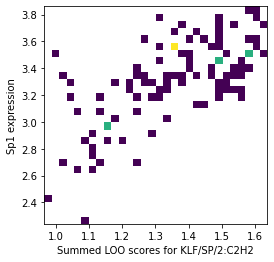

In [43]:
mpl.rcParams["figure.figsize"] = (4,4)
curr_fam = "KLF/SP/2:C2H2"
curr_gene = "Sp1"
w_e_df = get_subfam_exp_corr_df(curr_fam, curr_gene,
                       ad, all_loo_scores_df, motif_families_repro)
plt.hist2d(data=w_e_df, x='agg_scores', y='exp_scores', bins=30,
           norm=mpl.colors.LogNorm());
plt.xlabel("Summed LOO scores for " + curr_fam)
plt.ylabel(curr_gene + " expression");

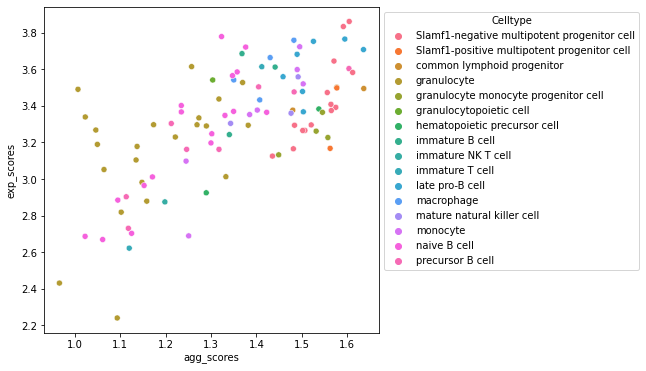

In [44]:
mpl.rcParams["figure.figsize"] = (6,6)
g = sns.scatterplot(data=w_e_df, x='agg_scores', y='exp_scores', hue='most_abundant_celltype')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Celltype')
plt.show()

## Aggregate influence scores

Sometimes it is useful to aggregate the motif scores for the motif families to get a sense of the collective impact of a motif family:

In [45]:
all_pools = []
all_subfam = []
all_bulk_sums = []
all_celltype = []
for subfam in motif_families_repro['subfamily'].unique():
    curr_subdf = all_loo_scores_df.loc[motif_families_repro[motif_families_repro['subfamily'] == subfam]['motif']]
    curr_bulk_sums = curr_subdf.sum(0)
    all_pools += list(curr_bulk_sums.index)
    all_subfam += [subfam for x in range(len(curr_bulk_sums))]
    all_bulk_sums += list(curr_bulk_sums)
    all_celltype += list(ad.obs['most_abundant_celltype'])
all_loo_scores_df_aggregate_melt = pd.DataFrame({'subfamily': all_subfam,
                                                 'sum': all_bulk_sums,
                                                 'celltype': all_celltype},
                                                index=all_pools)

In [46]:
all_loo_scores_df_aggregate_melt

,subfamily,sum,celltype
pseudobulk_0,ZFX:C2H2,0.257419,late pro-B cell
pseudobulk_1,ZFX:C2H2,0.220352,naive B cell
pseudobulk_2,ZFX:C2H2,0.270711,late pro-B cell
pseudobulk_3,ZFX:C2H2,0.263883,macrophage
pseudobulk_4,ZFX:C2H2,0.273127,late pro-B cell
...,...,...,...
pseudobulk_95,E2F/2:E2F,0.463091,Slamf1-negative multipotent progenitor cell
pseudobulk_96,E2F/2:E2F,0.333614,naive B cell
pseudobulk_97,E2F/2:E2F,0.483092,Slamf1-negative multipotent progenitor cell
pseudobulk_98,E2F/2:E2F,0.349964,immature T cell


## Save data

In [47]:
motif_families.to_csv(f"output/{exp_name}_motif_families.csv")
motif_families_repro.to_csv(f"output/{exp_name}_motif_families_repro.csv")
all_loo_scores_df_aggregate_melt.to_csv(f"output/{exp_name}_all_loo_scores_df_aggregate_melt.csv")

## Appendix

In the full Tabula Muris dataset case I would also do an analysis based on the cell type category, but that is slightly counterproductive in this case:

In [48]:
celltype_to_category = {
    "B cell": "immune",
    "Slamf1-negative multipotent progenitor cell": "immune", #
    "Slamf1-positive multipotent progenitor cell": "immune", #
    "T cell": "immune",
    "astrocyte": "macroglial",
    "basal cell": "epithelial",
    "basal cell of epidermis": "epithelial",
    "bladder cell": "connective",
    "bladder urothelial cell": "epithelial",
    "blood cell": "erythrocyte",
    "brain pericyte": "pericyte",
    "Brush cell of epithelium proper of large intestine": "epithelial",
    "cardiac muscle cell": "muscle",
    "classical monocyte": "immune",
    "common lymphoid progenitor": "immune", #
    "endocardial cell": "endothelial",
    "endothelial cell": "endothelial",
    "endothelial cell of hepatic sinusoid": "endothelial",
    "enterocyte of epithelium of large intestine": "epithelial",
    "enteroendocrine cell": "endocrine",
    "epidermal cell": "epithelial",
    "epithelial cell": "epithelial",
    "epithelial cell of large intestine": "epithelial",
    "epithelial cell of lung": "epithelial",
    "epithelial cell of proximal tubule": "epithelial",
    "erythrocyte": "erythrocyte",
    "fibroblast": "connective",
    "granulocyte": "immune",
    "granulocyte monocyte progenitor cell": "immune",
    "granulocytopoietic cell": "immune",
    "hematopoietic precursor cell": "immune", #
    "hepatocyte": "epithelial",
    "immature B cell": "immune",
    "immature T cell": "immune",
    "immature NK T cell": "immune",
    "keratinocyte": "epithelial",
    "keratinocyte stem cell": "epithelial",
    "kidney collecting duct epithelial cell": "epithelial",
    "Kupffer cell": "immune",
    "large intestine goblet cell": "epithelial",
    "late pro-B cell": "immune",
    "leukocyte": "immune",
    "luminal epithelial cell of mammary gland": "epithelial",
    "lung endothelial cell": "endothelial",
    "lymphocyte": "immune",
    "macrophage": "immune",
    "mature natural killer cell": "immune",
    "mesenchymal cell": "connective",
    "mesenchymal stem cell": "connective",
    "mesenchymal stem cell of adipose": "connective",
    "microglial cell": "immune",
    "monocyte": "immune",
    "myeloid cell": "immune",
    "myofibroblast cell": "connective",
    "naive B cell": "immune",
    "natural killer cell": "immune",
    "neuron": "neuronal",
    "oligodendrocyte": "macroglial",
    "oligodendrocyte precursor cell": "macroglial", #
    "pancreatic A cell": "endocrine",
    "pancreatic D cell": "endocrine",
    "pancreatic acinar cell": "exocrine",
    "pancreatic ductal cell": "epithelial",
    "precursor B cell": "immune",
    "pre-natural killer cell": "immune",
    "skeletal muscle satellite cell": "muscle",
    "skeletal muscle satellite stem cell": "muscle", #
    "smooth muscle cell": "muscle",
    "stromal cell": "connective",
    "stem cell of epidermis": "epithelial", #
    "type B pancreatic cell": "endocrine"
}
ad.obs["most_abundant_celltype_category"] = [celltype_to_category[x] for x in ad.obs['most_abundant_celltype']]
ad.obs["cell_type_category"] = [celltype_to_category[x] for x in ad.obs['most_abundant_celltype']]

/tmp/ipykernel_895/1794239175.py:74: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs["most_abundant_celltype_category"] = [celltype_to_category[x] for x in ad.obs['most_abundant_celltype']]


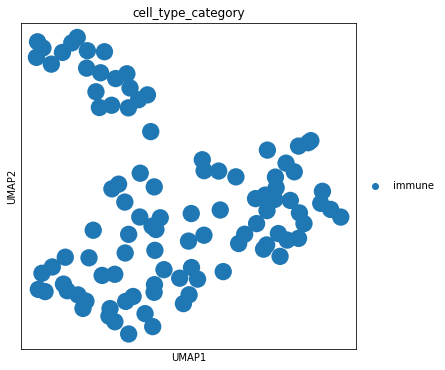

In [49]:
sc.pl.umap(ad, color='cell_type_category')